In [82]:
# SETTING UP THE TWITTER API

import os
import tweepy as tw
import pandas as pd

consumer_key = 'qWaI6kizU7SAcRNc6EnnoNChq'
consumer_secret = 'xumE7NgIZMiLCUXFeEl0pr3zhsuqdLvOPB0tG94HBQ8PgP2vsK'
access_token = '2747565082-8g1OYC9aFI4NxRInAV5ArxV1te4V6alDLHlQuNn'
access_token_secret = 'rDMmFApw3H5vL5KqVRxwRKdmJCkRdmrqjG8CCfmVroNKV'

auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth)

In [83]:
# PREPARING THE TRAINING DATASET (NIEK SANDERS' CORPUS OF OVER 5000 HAND-CLASSIFIED TWEETS)

# Storing training data with twitter ids and sentiments from Github in a CSV file.
import requests

url = 'https://raw.githubusercontent.com/karanluthra/twitter-sentiment-training/master/corpus.csv'
res = requests.get(url, allow_redirects=True)
with open(r'C:/Users/Raheyma Arshad/Desktop/Training IDs.csv','wb') as file:
    file.write(res.content)

# Opening the csv file as a pandas dataframe.     
train_ids_df = pd.read_csv(r'C:/Users/Raheyma Arshad/Desktop/Training IDs.csv', header = None)
del train_ids_df[0]
train_ids_df = train_ids_df.rename(columns={1: "Sentiment", 2: "ID"})

# Storing the twitter ids in dictionary and list forms.
train_ids_dict = train_ids_df.set_index('ID').T.to_dict('list')
train_ids = train_ids_df['ID'].tolist()

# Defining function to extract the full text of each tweet from twitter id.
def train_tweet_text(ids):
    tweet_status_list = api.statuses_lookup(ids)
    train_dict = {}
    for status in tweet_status_list:
        train_dict[status.id] = [status.text, train_ids_dict[status.id][0]]
    return train_dict

# We divide our training tweet ids into batches and run the above function on each batch. (Running on all the tweets ids 
# together raises error).
train_ids_count = len(train_ids)
train_batches = (train_ids_count - 1) // 50 + 1
train_sentiment_batch =  {}

for i in range(train_batches):
        train_batch = train_ids[i*50:(i+1)*50]
        train_dict= train_tweet_text(train_batch)
        train_sentiment_batch.update(train_dict)

# Converting the training data dictionary into a pandas dataframe.        
training_data = pd.DataFrame.from_dict(train_sentiment_batch, orient='index').reset_index()
del training_data['index']
training_data = training_data.rename(columns={0: "Tweet", 1: "Sentiment"})

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

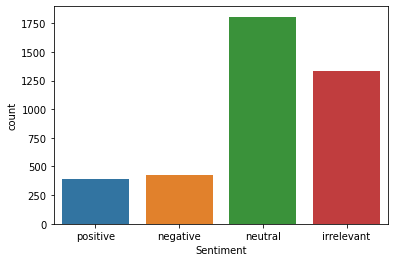

In [84]:
# CLEANING AND PREPROCESSING THE TRAINING DATASET

import re 

# Removing links that start with HTTP/HTTPS
training_data['Clean Tweet'] = training_data['Tweet'].apply(lambda x: re.sub('https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))

# Removing other URL links
training_data['Clean Tweet'] = training_data['Clean Tweet'].apply(lambda x: re.sub('[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))

# Lower casing
training_data['Clean Tweet'] = training_data['Clean Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing punctuation
training_data['Clean Tweet'] = training_data['Clean Tweet'].str.replace('[^\w\s]','')

# Removing stopwords
from nltk.corpus import stopwords
import nltk
stop = stopwords.words('english')
training_data['Clean Tweet'] = training_data['Clean Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Lemmatization
from textblob import Word
training_data['Clean Tweet'] = training_data['Clean Tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Plotting the distribution of sentiments in the training dataset
import seaborn as sns
import matplotlib as plt
sns.countplot(training_data['Sentiment'])

In [85]:
# TRAINING THE TFIDF-BASED SUPPORT VECTOR MACHINE (SVM) MODEL ON THE TRAINING DATASET

import sklearn
from sklearn.model_selection import train_test_split

# Splitting the dataset into train and test sets.
train, test = sklearn.model_selection.train_test_split(training_data, train_size=0.8, test_size=0.2)

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

pipeline = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=100, 
                                           learning_rate='optimal', tol=None))])

# Fitting the model on the train set.
svm = pipeline.fit(train['Clean Tweet'], train['Sentiment'])
test['Predicted Sentiment'] = svm.predict(test['Clean Tweet'])

print('\n', 'TFIDF-BASED SVM SENTIMENT IDENTIFICATION:', '\n')
print(test[['Tweet', 'Sentiment', 'Predicted Sentiment']].head(5))

from sklearn.metrics import f1_score, accuracy_score
svm_accuracy = accuracy_score(test['Sentiment'], test['Predicted Sentiment'])*100
svm_f1 = f1_score(test['Sentiment'], test['Predicted Sentiment'], average='macro')

print('\n', 'The accuracy of the TFIDF-based SVM sentiment identification is:', svm_accuracy)
print('The f1-score of the TFIDF-based SVM sentiment identification is:', svm_f1)


 TFIDF-BASED SVM SENTIMENT IDENTIFICATION: 

                                                  Tweet Sentiment  \
584   iPhone 4S First Weekend Sales Top Four Million...   neutral   
2071  Oh how much do I loathe #microsoft??? An hour ...  negative   
405   Noticed how @apple has added the like & tweet ...   neutral   
1221  Fight: Galaxy Nexus vs. Droid RAZR vs. iPhone ...   neutral   
243   @Apple would do better to inform customers pro...  negative   

     Predicted Sentiment  
584              neutral  
2071             neutral  
405              neutral  
1221             neutral  
243              neutral  

 The accuracy of the TFIDF-based SVM sentiment identification is: 74.96839443742098
The f1-score of the TFIDF-based SVM sentiment identification is: 0.5594761578888932


<ipython-input-85-2829efe8315c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted Sentiment'] = svm.predict(test['Clean Tweet'])


In [86]:
# PREPARING THE COVID-19 VACCINE TWEETS DATASET (i.e. the dataset that needs to be classified)

'''
We are using 'snscrape' to collect the tweets.
For this package we will have to run the following commands in the command prompt/anaconda prompt of our computers.
(This prompt is different from the python environment we are using) The commands are:

snscrape twitter-search "#covid-19vaccine since:2020-09-01 until:2020-09-30" > tweets1.txt
snscrape twitter-search "#COVID-19Vaccine since:2020-09-01 until:2020-09-30" > tweets2.txt
snscrape twitter-search "#covidvaccine since:2020-09-01 until:2020-09-30" > tweets3.txt
snscrape twitter-search "#coronavirusvaccine since:2020-09-01 until:2020-09-30" > tweets4.txt
snscrape twitter-search "#coronavaccine since:2020-09-01 until:2020-09-30" > tweets5.txt

Each command is run separately in the prompt and returns URL ids for the tweets in a text file.
Then we will use the following commands to extract the URL ids and finally the tweet texts from the text files.

Reference: https://medium.com/@jcldinco/downloading-historical-tweets-using-tweet-ids-via-snscrape-and-tweepy-5f4ecbf19032
'''

# Converting the text files into a single pandas dataframe.
tweet_url = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\tweets1.txt", index_col= None, header = None, names = ["links"])
tweet_url2 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\tweets2.txt", index_col= None, header = None, names = ["links"])
tweet_url3 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\tweets3.txt", index_col= None, header = None, names = ["links"])
tweet_url4 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\tweets4.txt", index_col= None, header = None, names = ["links"])
tweet_url5 = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\tweets5.txt", index_col= None, header = None, names = ["links"])

tweet_url = tweet_url.append(tweet_url2, ignore_index=True)
tweet_url = tweet_url.append(tweet_url3, ignore_index=True)
tweet_url = tweet_url.append(tweet_url4, ignore_index=True)
tweet_url = tweet_url.append(tweet_url5, ignore_index=True)

# Splitting the URLs and getting the id of each tweet.
tweet_url['id'] = tweet_url.apply(lambda x: x["links"].split("/")[-1], axis=1)
# Saving the tweet ids in a list.
ids = tweet_url['id'].tolist()

# Defining function to get the text from each tweet.
def tweet_text(ids):
    tweet_status_list = api.statuses_lookup(ids, tweet_mode= "extended")
    text = pd.DataFrame()
    for status in tweet_status_list:
            tweet_text = {"tweet":status.full_text}
            text = text.append(tweet_text, ignore_index = True)
    text.to_csv(r"C:\Users\Raheyma Arshad\Desktop\Vaccine Tweets.csv", mode="a")
    
# We divide our tweet ids into batches and run the above function on each batch. (Running on all the tweets ids together 
# raises error)
ids_count = len(ids)
batches = (ids_count - 1) // 50 + 1

for i in range(batches):
        batch = ids[i*50:(i+1)*50]
        result = tweet_text(batch)

In [87]:
# CLEANING AND PREPROCESSING THE TEST DATASET (Same cleaning as the Training Dataset)

covid_vaccine_data = pd.read_csv(r"C:\Users\Raheyma Arshad\Desktop\Vaccine Tweets.csv")
del covid_vaccine_data['Unnamed: 0']

# Removing links that start with HTTP/HTTPS
covid_vaccine_data['Clean Tweet'] = covid_vaccine_data['tweet'].apply(lambda x: re.sub('https?:\/\/(www\.)?[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))

# Removing other URL links
covid_vaccine_data['Clean Tweet'] = covid_vaccine_data['Clean Tweet'].apply(lambda x: re.sub('[-a-zA-Z0–9@:%._\+~#=]{2,256}\.[a-z]{2,6}\b([-a-zA-Z0–9@:%_\+.~#?&//=]*)', '', x))

# Lower casing
covid_vaccine_data['Clean Tweet'] = covid_vaccine_data['Clean Tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing punctuation
covid_vaccine_data['Clean Tweet'] = covid_vaccine_data['Clean Tweet'].str.replace('[^\w\s]','')

# Removing stopwords
covid_vaccine_data['Clean Tweet'] = covid_vaccine_data['Clean Tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# Lemmatization
covid_vaccine_data['Clean Tweet'] = covid_vaccine_data['Clean Tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

<AxesSubplot:xlabel='Predicted Sentiment', ylabel='count'>

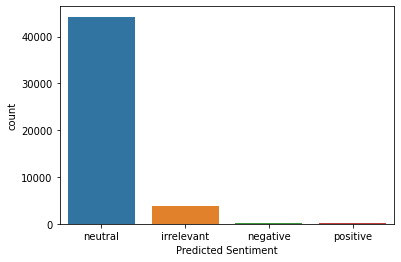

In [88]:
# USING THE SVM MODEL TO PREDICT SENTIMENTS OF COVID-19 VACCINE TWEETS

covid_vaccine_data['Predicted Sentiment'] = svm.predict(covid_vaccine_data['Clean Tweet'])

# Plotting the distribution of sentiments in the covid-19 vaccine tweets dataset
sns.countplot(covid_vaccine_data['Predicted Sentiment'])